# 决策树和随机森林

集成方法，学习效果经常出人意料，若干个评估器的多数投票的最终效果往往优于单个评估器的投票的效果

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 决策树

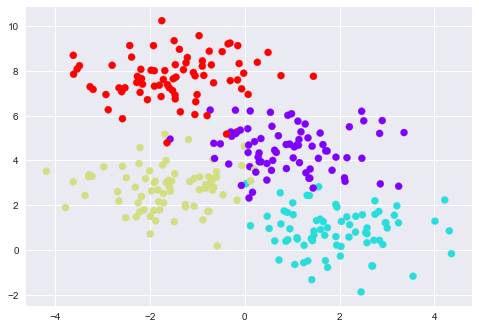

In [2]:
# 创建数据
from sklearn.datasets import make_blobs

X,y = make_blobs(n_samples=300, centers=4,
                random_state=0, cluster_std=1.0)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='rainbow')

In [7]:
X[:6,:]

array([[ 0.02458305,  2.96215652],
       [-1.52392631,  7.12573205],
       [ 1.27450825,  5.63017322],
       [-0.86552334,  7.80121774],
       [ 0.74874067,  2.55579434],
       [ 4.35918422, -0.16235216]])

### 决策树划分

In [8]:
from sklearn.tree import DecisionTreeClassifier
# 可以进行多分类
tree = DecisionTreeClassifier().fit(X,y)

In [25]:
# 对分类器的效果进行可视化
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # 画出训练数据
    ax.scatter(X[:,0], X[:,1], c=y, s=30, cmap=cmap,
              clim=(y.min(),y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 用于评估器拟合数据
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                        np.linspace(*ylim, num=200))
    # 形成数据点
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # 为结果标色
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes+1)-0.5,
                           cmap=cmap,
                           zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

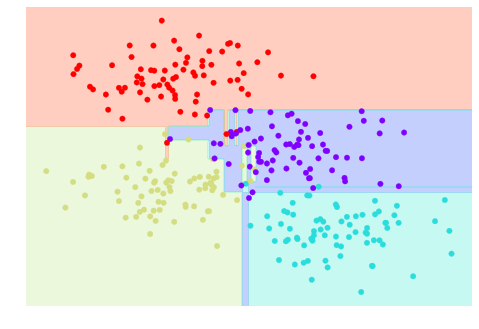

In [26]:
visualize_classifier(DecisionTreeClassifier(), X, y)

### 交互式可视化

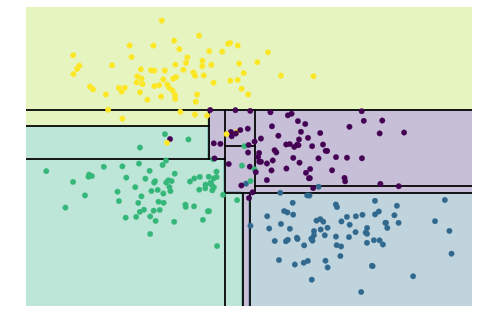

In [28]:
import helpers_05_08
helpers_05_08.plot_tree_interactive(X,y)

可以发现，第五层开始有过拟合的倾向

### 过拟合

决策树非常容易陷得很深，往往会拟合局部数据，而没有整个数据分布的大局观。  
加入我们训练两颗树，每棵树拟合一半数据，然后组合起来做决策，就可能能获得更好的结果

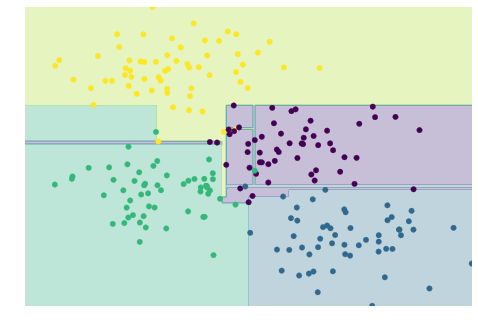

In [29]:
helpers_05_08.randomized_tree_interactive(X,y)

## 集成算法：随机森林

在sklearn中，Bagging 本身是一种算法，随机森林可以看做是底层是决策树的Bagging算法

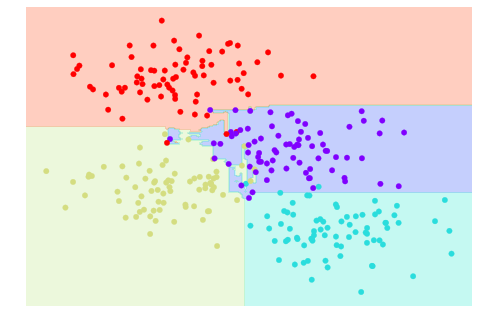

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                       random_state=1)

visualize_classifier(bag, X, y)

就感觉比单决策树的分类要平整

当然sklearn也帮忙封装了一个随机森林评估器

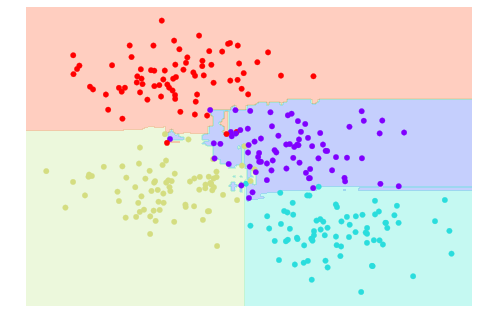

In [31]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, random_state=0)
visualize_classifier(model, X, y)

## 随机森林回归

处理连续变量，底层决策树应该是回归树

<Container object of 3 artists>

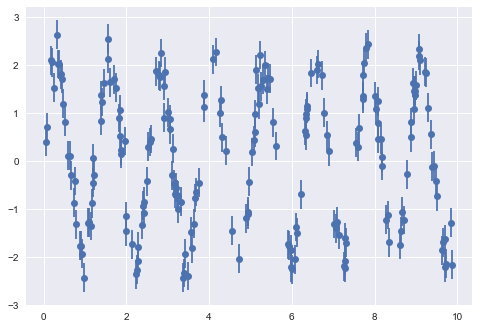

In [33]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5*x)
    slow_oscillation = np.sin(5*x)
    noise = sigma * rng.randn(len(x))
    
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o')

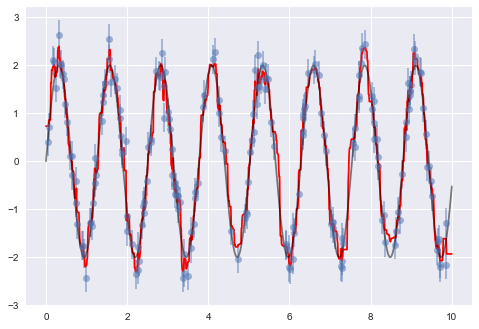

In [34]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(200)
forest.fit(x[:,None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit,yfit,'-r')
plt.plot(xfit, ytrue, '-k',alpha=0.5)

## 案例： 用随机森林识别手写数字

In [35]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

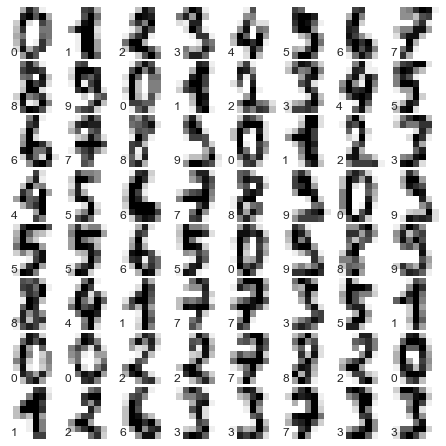

In [36]:
# 画数字
fig = plt.figure(figsize = (6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks = [], yticks = [])
    ax.imshow(digits.images[i], cmap = plt.cm.binary, interpolation = 'nearest')
    
    # 用target值给图像做标注
    ax.text(0,7,str(digits.target[i]))
    

In [37]:
# 用随机森林对数字进行分类

from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state = 0)

model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

In [38]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       0.98      0.98      0.98        43
          2       0.95      1.00      0.98        42
          3       0.98      0.96      0.97        46
          4       0.97      1.00      0.99        37
          5       0.98      0.96      0.97        49
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.98      0.98      0.98        47

avg / total       0.98      0.98      0.98       450



Text(125.71,0.5,'pred label')

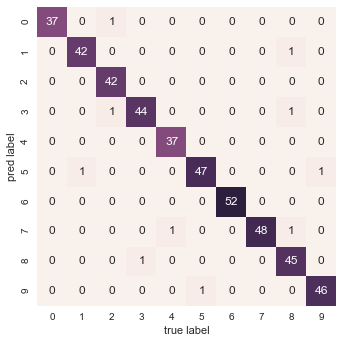

In [40]:
# 混淆矩阵

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('pred label')

会发现效果挺好的

## 总结

优点：
* 集成算法，训练和预测速度快，因为可以并行计算
* 利用多个评估器之间的多数投票可以给出概率的估计值
* 无参数模型，很灵活，在其他评估器都欠拟合的任务中表现突出

缺点：
* 不太容易解释